###Importing Modules

In [ ]:
import os
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report
)

from tqdm import tqdm
from google.colab import drive


###Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Fold1_part2.zip'

###Unzip

In [ ]:
extract_path = '/content/dataset'
os.makedirs(extract_path, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

base_path = '/content/dataset'

###Custom PyTorch Dataset for Frame-Level Video Processing

In [ ]:
class VideoFrameDataset(Dataset):
    def __init__(self, base_path, frame_interval=10, resize=(112, 112), transform=None):
        self.resize = resize
        self.transform = transform
        self.frame_paths = []
        self.labels = []
        self.frame_interval = frame_interval

        folder_path = os.path.join(base_path, "Fold1_part2")
        self._extract_frame_info(folder_path)

    def _extract_frame_info(self, folder_path):
        video_info = []
        subjects = sorted(os.listdir(folder_path))
        for subject_folder in subjects:
            subject_path = os.path.join(folder_path, subject_folder)
            if not os.path.isdir(subject_path):
                continue

            videos = sorted([v for v in os.listdir(subject_path) if v.endswith('.mp4')])
            for video_file in videos:
                label = 1 if video_file.startswith('10') else 0
                video_path = os.path.join(subject_path, video_file)
                video_info.append((video_path, label))

        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            futures = [executor.submit(self._get_frame_info, vid_path, label)
                      for vid_path, label in video_info]

            for future in tqdm(concurrent.futures.as_completed(futures),
                              total=len(video_info), desc="Extracting frame info"):
                frame_paths, frame_labels = future.result()
                self.frame_paths.extend(frame_paths)
                self.labels.extend(frame_labels)

    def _get_frame_info(self, video_path, label):
        frame_paths = []
        labels = []

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return frame_paths, labels

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_to_extract = list(range(0, total_frames, self.frame_interval))

        for frame_idx in frames_to_extract:
            frame_paths.append((video_path, frame_idx))
            labels.append(label)

        cap.release()
        return frame_paths, labels

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        video_path, frame_idx = self.frame_paths[idx]
        label = self.labels[idx]

        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()

        if not ret:
            frame = np.zeros((self.resize[0], self.resize[1], 3), dtype=np.uint8)
        else:
            frame = cv2.resize(frame, self.resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert to tensor and normalize
        frame = frame.transpose((2, 0, 1)) / 255.0
        frame = torch.FloatTensor(frame)

        if self.transform:
            frame = self.transform(frame)

        return frame, torch.tensor(label, dtype=torch.long)

###Create DataLoaders

In [ ]:
def create_data_loaders(base_path, batch_size=16, frame_interval=10,
                        train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset = VideoFrameDataset(base_path, frame_interval=frame_interval)

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=4)

    print(f"Created data loaders with {train_size} training, {val_size} validation, "
          f"and {test_size} test samples")

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_data_loaders(base_path)

Extracting frame info: 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]

Created data loaders with 12012 training, 2574 validation, and 2575 test samples



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
for images, labels in train_loader:
    print(labels.shape)
    print("Train batch shape:", images.shape)
    break

torch.Size([16])
Train batch shape: torch.Size([16, 3, 112, 112])


###Visualization

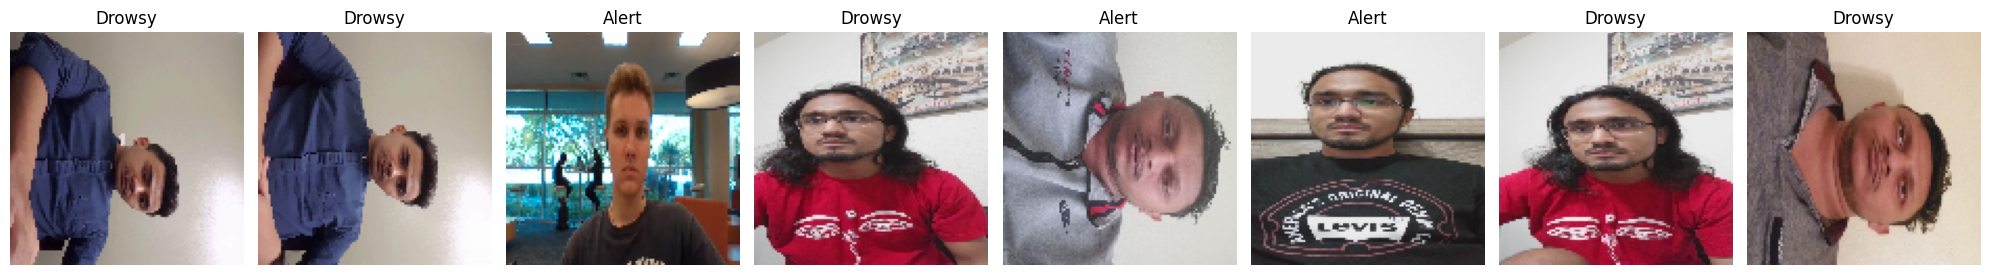

In [ ]:
def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    images = images[:8]
    labels = labels[:8]

    fig, axs = plt.subplots(1, 8, figsize=(20, 4))

    for i in range(8):
        img = images[i].permute(1, 2, 0).numpy()
        axs[i].imshow(img)
        axs[i].set_title('Alert' if labels[i].item() == 0 else 'Drowsy')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch(train_loader)


### DrowsinessCNN: Custom Convolutional Model
This architecture is designed to classify driver states (Alert vs Drowsy) from individual video frames.
It consists of four convolutional blocks followed by fully connected layers with batch normalization and dropout
for regularization.


In [ ]:
class DrowsinessCNN(nn.Module):
    def __init__(self, input_size=112):
        super(DrowsinessCNN, self).__init__()
        assert input_size == 112
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.feature_size = 256 * 7 * 7

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return torch.sigmoid(x).squeeze(1)

    def extract_features(self, x):

        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return x


####Model Initialization

In [ ]:
model = DrowsinessCNN()


In [ ]:
from torchsummary import summary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DrowsinessCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
input_size = (3, 112, 112)

# Print summary
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,248
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
         MaxPool2d-7           [-1, 32, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          18,496
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,928
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
        MaxPool2d-14           [-1, 64,

####Criterion & Optimizer

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


###Training

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            predicted = (outputs>=0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_train_loss = train_loss / total

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                predicted = (outputs>=0.5).float()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val
        avg_val_loss = val_loss / total_val

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model updated and saved.")




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DrowsinessCNN()

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

Epoch 1/10 - Training: 100%|██████████| 751/751 [2:16:15<00:00, 10.89s/it]


Epoch 1 Summary:
  Train Loss: 18.7292, Accuracy: 0.9948
  Val   Loss: 18.6162, Accuracy: 0.9996

✅ Best model updated and saved.


Epoch 2/10 - Training:  48%|████▊     | 362/751 [1:06:16<1:01:24,  9.47s/it]

###Evaluation

In [ ]:
def evaluate_binary_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            probs = outputs
            predicted = (probs >= 0.5).float()

            test_loss += loss.item() * images.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = np.mean(all_preds == all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)

    fpr, tpr, thresholds_roc = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(all_labels, all_probs)
    average_precision = average_precision_score(all_labels, all_probs)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print("\n===== Binary Classification Model Evaluation =====")
    print(f"Test Loss: {test_loss/len(all_labels):.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (% of predicted drowsy that are correct)")
    print(f"Recall/Sensitivity: {recall:.4f} (% of actual drowsy correctly identified)")
    print(f"Specificity: {specificity:.4f} (% of actual awake correctly identified)")
    print(f"F1 Score: {f1:.4f} (harmonic mean of precision and recall)")


    # Confusion matrix values
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn} (Awake predicted as Awake)")
    print(f"False Positives: {fp} (Awake predicted as Drowsy)")
    print(f"False Negatives: {fn} (Drowsy predicted as Awake)")
    print(f"True Positives: {tp} (Drowsy predicted as Drowsy)")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Awake', 'Drowsy']))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Awake', 'Drowsy'],
                yticklabels=['Awake', 'Drowsy'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
    }




In [ ]:
def visualize_predictions(model, test_loader, device, num_samples=10):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            batch_size = images.size(0)
            if len(all_images) + batch_size > num_samples:
                images = images[:num_samples-len(all_images)]
                labels = labels[:num_samples-len(all_images)]
                if len(images) == 0:
                    break

            images_cpu = images.clone().cpu()
            labels_cpu = labels.clone().cpu()

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = outputs
            preds = (probs >= 0.5).float()

            all_images.extend(images_cpu)
            all_labels.extend(labels_cpu)
            all_preds.extend(preds.cpu())
            all_probs.extend(probs.cpu())

            if len(all_images) >= num_samples:
                break

    # Plot
    fig, axes = plt.subplots(nrows=min(5, num_samples), ncols=2, figsize=(12, 15))
    axes = axes.flatten() if num_samples > 1 else [axes]

    for i in range(min(num_samples, len(all_images))):
        img = all_images[i].permute(1, 2, 0).numpy()

        if img.max() > 1:
            img = img / 255.0

        if img.shape[2] == 1:
            img = img.squeeze()

        true_label = all_labels[i].item()
        pred_label = all_preds[i].item()
        prob = all_probs[i].item()

        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"True: {'Drowsy' if true_label == 1 else 'Awake'}\n"
                     f"Pred: {'Drowsy' if pred_label == 1 else 'Awake'} ({prob:.2f})")
        ax.axis('off')

        if true_label == pred_label:
            ax.title.set_color('green')
        else:
            ax.title.set_color('red')

    plt.tight_layout()
    plt.savefig('predictions_visualization.png')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



===== Binary Classification Model Evaluation =====
Test Loss: 0.0531
Accuracy: 1.0000
Precision: 1.0000 (% of predicted drowsy that are correct)
Recall/Sensitivity: 1.0000 (% of actual drowsy correctly identified)
Specificity: 1.0000 (% of actual awake correctly identified)
F1 Score: 1.0000 (harmonic mean of precision and recall)

Confusion Matrix:
True Negatives: 1324 (Awake predicted as Awake)
False Positives: 0 (Awake predicted as Drowsy)
False Negatives: 0 (Drowsy predicted as Awake)
True Positives: 1251 (Drowsy predicted as Drowsy)

Classification Report:
              precision    recall  f1-score   support

       Awake       1.00      1.00      1.00      1324
      Drowsy       1.00      1.00      1.00      1251

    accuracy                           1.00      2575
   macro avg       1.00      1.00      1.00      2575
weighted avg       1.00      1.00      1.00      2575



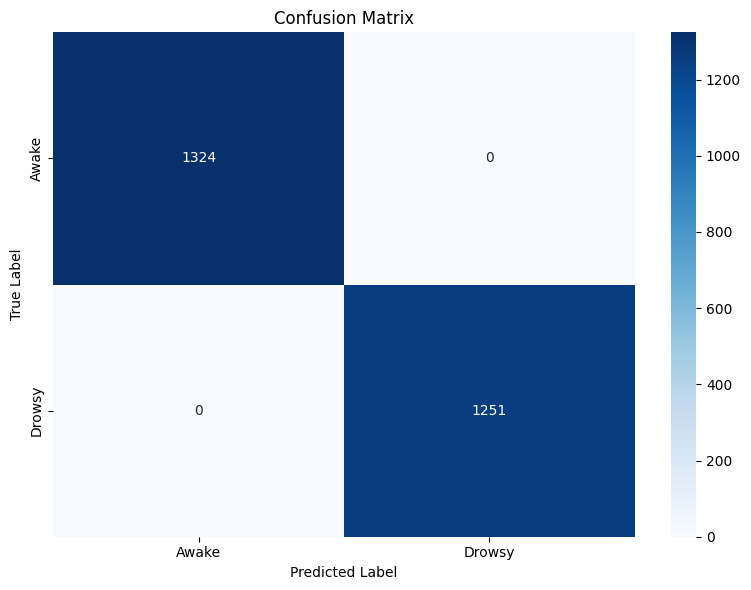

In [ ]:
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
results = evaluate_binary_model(model, test_loader, criterion, device)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


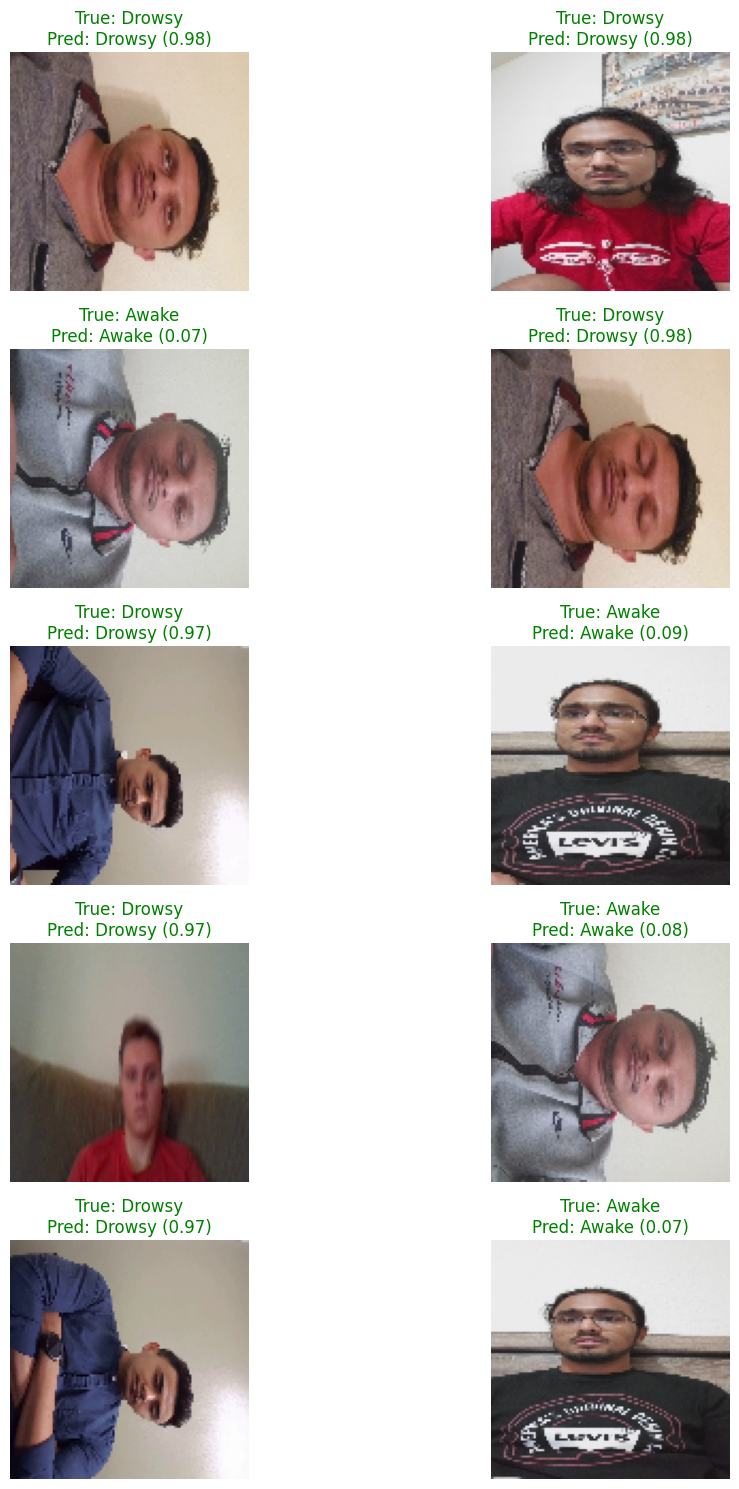

In [ ]:
visualize_predictions(model, test_loader, device, num_samples=10)